# Bias Detection with SageMaker Clarify

In [1]:
import boto3
import sagemaker
import botocore.config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyathena import connect

Matplotlib is building the font cache; this may take a moment.


In [2]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [3]:
print(bucket)
print(role)
print(region)

sagemaker-us-east-2-003294323742
arn:aws:iam::003294323742:role/service-role/AmazonSageMaker-ExecutionRole-20221228T123920
us-east-2


In [4]:
database_name = 'dsaws'
table_name = 'amazon_reviews_parquet'

In [5]:
# Set Athena query results s3 bucket
s3_staging_dir = 's3://{}/athena/staging'.format(bucket)

# Set up PyAthena connection
conn = connect(region_name = region, s3_staging_dir = s3_staging_dir)

We will be take a sample of the Amazon Customer Reviews Dataset to conduct a Bias Report. Create pandas dataframe from each of the product categories

In [6]:
# Gift Cards
gift_cards_query = """
SELECT * 
FROM {}.{}
WHERE product_category = 'Gift Card'
""".format(database_name, table_name)

gift_cards_df = pd.read_sql(gift_cards_query, conn)

In [7]:
# Software
software_query = """
SELECT *
FROM {}.{}
WHERE product_category = 'Software'
""".format(database_name, table_name)

software_df = pd.read_sql(software_query, conn)

In [8]:
# Video games
video_games_query = """
SELECT *
FROM {}.{}
WHERE product_category = 'Digital_Video_Games'
""".format(database_name, table_name)

video_games_df = pd.read_sql(video_games_query, conn)

In [9]:
df = pd.concat([gift_cards_df, software_df, video_games_df], ignore_index = True, sort = False)
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,year,review_date,product_category
0,US,3901355,R2B7DTON5L1DRV,B00AF0K82U,938949631,Amazon.com Gift Card - Upload Your Photo (Prin...,3,0,0,N,Y,It was OK,I would have expected a more elaborate card fr...,2014,2014-01-25,Gift Card
1,US,42940281,R38K00QVAY8SUT,B007RZ6DSO,473048287,Amazon.com eGift Cards,5,0,0,N,Y,I like it,I like the idea of having the personal photo w...,2014,2014-01-25,Gift Card
2,US,38578185,R3EX4L235BJ4AY,B00G4IWEZG,291625889,Amazon Gift Card - Print - Merry Christmas (Pine),5,0,0,N,N,Great resource,"Enjoyed the ease of purchase, gift card & dow...",2014,2014-01-25,Gift Card
3,US,39499599,R1X9E7I188K34C,B00G4IV2VI,538766567,Amazon eGift Card - Merry Christmas (Pine),5,0,0,N,Y,it's a lifesaver,It worked really well and fast. It saved me be...,2014,2014-01-25,Gift Card
4,US,52948476,R1WXK8RMFOGQLF,B00CRQ4CF4,408939516,Amazon eGift Card - #1 Dad,5,0,0,N,Y,Good choice,"Gift cards are always a good choice, especiall...",2014,2014-01-25,Gift Card


<AxesSubplot:xlabel='star_rating', ylabel='count'>

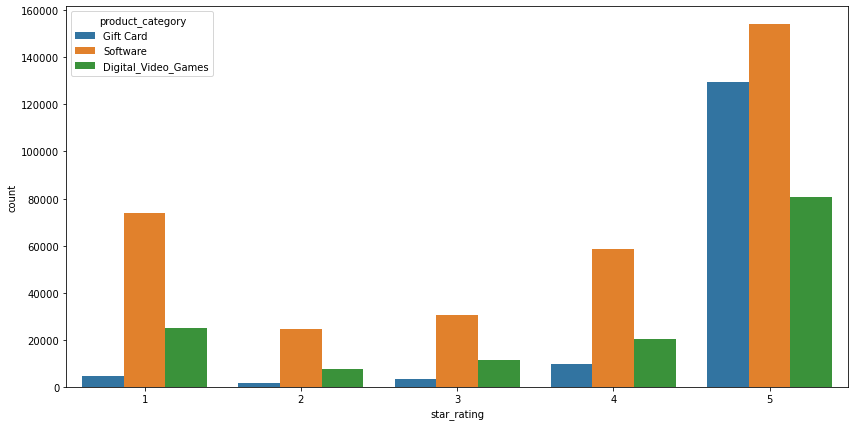

In [10]:
fig = plt.figure(figsize = (14,7))
sns.countplot(data = df, x = 'star_rating', hue = 'product_category')

# Upload Sample Data to S3

In [46]:
data_path = 'data/amazon_reviews_sample.csv'
df.to_csv(data_path, index = False, header = True)

data_s3_uri = sagemaker_session.upload_data(bucket = bucket, key_prefix = "bias/sample", path = data_path)
print(data_s3_uri)

s3://sagemaker-us-east-2-003294323742/bias/sample/amazon_reviews_sample.csv


# Detect Bias with SageMaker Clarify

In [12]:
from sagemaker import clarify

bias_report_output_path = 's3://{}/bias/bias_report_sample'.format(bucket)

In [13]:
# Clarify configuration

data_config = clarify.DataConfig(
    s3_data_input_path = data_s3_uri,
    s3_output_path= bias_report_output_path,
    label = 'star_rating',
    headers = df.columns.to_list(),
    dataset_type = 'text/csv'
)

## Setup Clarify Configuration for Bias Metrics

In [14]:
# Sensitive columns (facets) which is the product_category. Desirable outcomes (label_values_or_thresholds) which are the positive outcomes star rating 5 and 4

data_bias_config = clarify.BiasConfig(
    label_values_or_threshold = [5,4],
    facet_name = 'product_category'
)

## Setup SageMaker Processing Job

In [15]:
clarify_processor = clarify.SageMakerClarifyProcessor(
    role = role,
    instance_count = 1, # if we have a lot of data we can add more instances to process data in parallel with 5 instances for example.
    instance_type = 'ml.m5.xlarge',
    sagemaker_session = sagemaker_session
)

## Run Processing Job

In [16]:
clarify_processor.run_pre_training_bias(
    data_config = data_config,
    data_bias_config = data_bias_config,
    methods = 'all',
    wait = False,
    logs = False
)

INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2022-12-31-19-15-40-555



Job Name:  Clarify-Pretraining-Bias-2022-12-31-19-15-40-555
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-003294323742/bias/sample/amazon_reviews_sample.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-003294323742/bias/bias_report_sample/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-003294323742/bias/bias_report_sample', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


In [17]:
bias_processing_job_name = clarify_processor.latest_job.job_name
print(bias_processing_job_name)

Clarify-Pretraining-Bias-2022-12-31-19-15-40-555


We can check our S3 Bucket for the Generated Bias Reports

# Detecting Bias with SageMaker Clarify Open Source

Alternatively, we can use the smclarify Python library to detect biase and class imbalance from a Python Script using a CSV file.

In [47]:
#!pip install smclarify

In [19]:
from smclarify.bias import report

In [22]:
facet_column = report.FacetColumn(name = 'product_category')

label_column = report.LabelColumn(
    name = 'star_rating',
    data = df['star_rating'],
    positive_label_values = [5,4]
)

group_variable = df['product_category']

results = report.bias_report(
    df,
    facet_column,
    label_column,
    stage_type = report.StageType.PRE_TRAINING,
    group_variable = group_variable
)

INFO:smclarify.bias.metrics.common:data uniqueness fraction: 7.85610136256222e-06
INFO:smclarify.bias.metrics.common:data uniqueness fraction: 4.713660817537332e-06


In [23]:
results

[{'value_or_threshold': 'Gift Card',
  'metrics': [{'name': 'CDDL',
    'description': 'Conditional Demographic Disparity in Labels (CDDL)',
    'value': 0.0},
   {'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.5315061089044195},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': -0.29253135565529187},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.06974241015529553},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.3716624575519059},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.2925313556552919},
   {'name': 'LP', 'description': 'L-p Norm (LP)', 'value': 0.4137018105871012},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.29253135565529187}]},
 {'value_or_threshold': 'Software',
  'metrics': [{'name': 'CDDL',
    'description': 'Conditional Demograph

In [38]:
gift_card_results = pd.DataFrame(results[0]['metrics'])
software_results = pd.DataFrame(results[1]['metrics'])
video_games_results = pd.DataFrame(results[2]['metrics'])

In [39]:
gift_card_results

,name,description,value
0,CDDL,Conditional Demographic Disparity in Labels (C...,0.000000
1,CI,Class Imbalance (CI),0.531506
2,DPL,Difference in Positive Proportions in Labels (...,-0.292531
3,JS,Jensen-Shannon Divergence (JS),0.069742
4,KL,Kullback-Liebler Divergence (KL),0.371662
5,KS,Kolmogorov-Smirnov Distance (KS),0.292531
6,LP,L-p Norm (LP),0.413702
7,TVD,Total Variation Distance (TVD),0.292531


In [40]:
software_results

,name,description,value
0,CDDL,Conditional Demographic Disparity in Labels (C...,0.000000
1,CI,Class Imbalance (CI),-0.074498
2,DPL,Difference in Positive Proportions in Labels (...,0.195353
3,JS,Jensen-Shannon Divergence (JS),0.024015
4,KL,Kullback-Liebler Divergence (KL),0.090356
5,KS,Kolmogorov-Smirnov Distance (KS),0.195353
6,LP,L-p Norm (LP),0.276271
7,TVD,Total Variation Distance (TVD),0.195353


In [41]:
video_games_results

,name,description,value
0,CDDL,Conditional Demographic Disparity in Labels (C...,0.000000
1,CI,Class Imbalance (CI),0.542992
2,DPL,Difference in Positive Proportions in Labels (...,0.022155
3,JS,Jensen-Shannon Divergence (JS),0.000296
4,KL,Kullback-Liebler Divergence (KL),0.001174
5,KS,Kolmogorov-Smirnov Distance (KS),0.022155
6,LP,L-p Norm (LP),0.031332
7,TVD,Total Variation Distance (TVD),0.022155


# Reduce Biase by Balancing Data

In [42]:
df_group_by = df.groupby(['product_category', 'star_rating'])
df_balanced = df_group_by.apply(lambda x: x.sample(df_group_by.size().min()).reset_index(drop = True))
df_balanced.head()

marketplace customer_id       review_id  \
product_category    star_rating                                             
Digital_Video_Games 1           0          US     3366112  R1L04IKYXYV1VC   
                                1          US    24379591  R250Z0FV5NTHPB   
                                2          US    10226292  R3GPSE9QVJG93F   
                                3          US     8287984  R3O3V7LK7C6TT7   
                                4          US    13954434   RYXG9BO0Z1VM2   

                                   product_id product_parent  \
product_category    star_rating                                
Digital_Video_Games 1           0  B00AIALGZK      536445610   
                                1  B004774738      300848641   
                                2  B00FPQFXGK      613534992   
                                3  B00F4CF7L6      341969535   
                                4  B007VTVRFA      402222185   

                                                                 product_title  \
product_category    star_rating                                                  
Digital_Video_Games 1           0            Euro Truck Simulator 2 [Download]   
                                1  The Sims 3: World Adventures Expansion Pack   
                                2                                   Watch Dogs   
                                3                          Xbox Live Gift Card   
                                4                    SimCity - Limited Edition   

                                   star_rating  helpful_votes  total_votes  \
product_category    star_rating                                              
Digital_Video_Games 1           0            1              0            1   
                                1            1              0            1   
                                2            1              0            2   
                                3            1              2            4   
                                4            1              1            1   

                                  vine verified_purchase  \
product_category    star_rating                            
Digital_Video_Games 1           0    N                 Y   
                                1    N                 Y   
                                2    N                 N   
                                3    N                 Y   
                                4    N                 N   

                                                     review_headline  \
product_category    star_rating                                        
Digital_Video_Games 1           0                         1 waste of   
                                1             Fun while it lasted...   
                                2               Trash. Learn 2 code.   
                                3  No email confirmation and no code   
                                4                    Save your money   

                                                                         review_body  \
product_category    star_rating                                                        
Digital_Video_Games 1           0  it dint work on my windows 8.1<br />waste of m...   
                                1  Initially, the game was great. A nice change f...   
                                2               pile of trash, learn to code scrubs.   
                                3  I recently bought this item from the mobile we...   
                                4  Just as everyone is saying, so many server iss...   

                                   year review_date     product_category  
product_category    star_rating                                           
Digital_Video_Games 1           0  2015  2015-01-22  Digital_Video_Games  
                                1  2012  2012-10-25  Digital_Video_Games  
                                2  2014  2014-08-02  Digital_Video_Games  
     

<AxesSubplot:xlabel='star_rating', ylabel='count'>

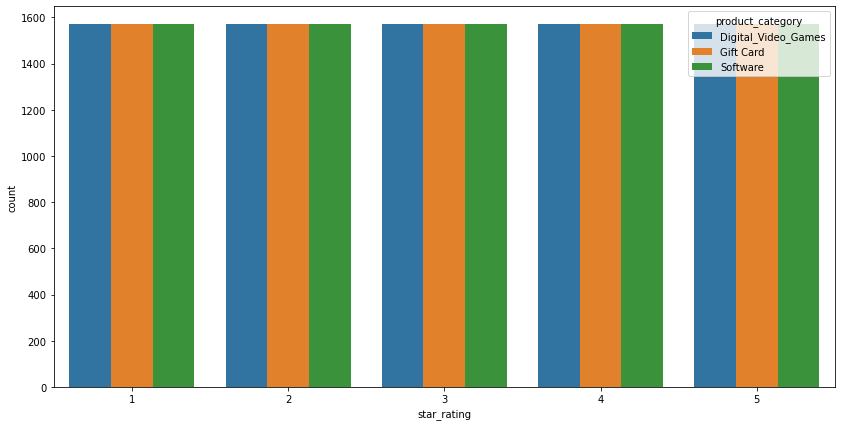

In [43]:
fig = plt.figure(figsize = (14,7))
sns.countplot(data = df_balanced, x = 'star_rating', hue = 'product_category')

# Upload Balanced Sample Data to S3

In [45]:
balanced_data_path = 'data/amazon_reviews_balanced_sample.csv'
df_balanced.to_csv(balanced_data_path, index = False, header = True)

balanced_data_s3_uri = sagemaker_session.upload_data(bucket = bucket, key_prefix = "bias/sample", path = balanced_data_path)
print(balanced_data_s3_uri)

s3://sagemaker-us-east-2-003294323742/bias/sample/amazon_reviews_balanced_sample.csv


# Detect Bias with SageMaker Clarify

In [48]:
balanced_bias_report_output_path = 's3://{}/bias/balanced_bias_report_sample'.format(bucket)

In [50]:
# Clarify configuration

balanced_data_config = clarify.DataConfig(
    s3_data_input_path = balanced_data_s3_uri,
    s3_output_path= balanced_bias_report_output_path,
    label = 'star_rating',
    headers = df_balanced.columns.to_list(),
    dataset_type = 'text/csv'
)

## Setup Clarify Configuration for Bias Metrics

In [51]:
balanced_data_bias_config = clarify.BiasConfig(
    label_values_or_threshold = [5,4],
    facet_name = 'product_category'
)

## Setup SageMaker Processing Job

In [52]:
clarify_processor = clarify.SageMakerClarifyProcessor(
    role = role,
    instance_count = 1, # if we have a lot of data we can add more instances to process data in parallel with 5 instances for example.
    instance_type = 'ml.m5.xlarge',
    sagemaker_session = sagemaker_session
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


## Run Processing Job

In [53]:
clarify_processor.run_pre_training_bias(
    data_config = balanced_data_config,
    data_bias_config = balanced_data_bias_config,
    methods = 'all',
    wait = False,
    logs = False
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'year', 'review_date', 'product_category'], 'label': 'star_rating', 'label_values_or_threshold': [5, 4], 'facet': [{'name_or_index': 'product_category'}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}}}
INFO:sagemaker:Creating processing-job with name Clarify-Pretraining-Bias-2022-12-31-19-50-30-944



Job Name:  Clarify-Pretraining-Bias-2022-12-31-19-50-30-944
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-003294323742/bias/sample/amazon_reviews_balanced_sample.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-2-003294323742/bias/balanced_bias_report_sample/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-2-003294323742/bias/balanced_bias_report_sample', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]


In [54]:
balanced_bias_processing_job_name = clarify_processor.latest_job.job_name
print(balanced_bias_processing_job_name)

Clarify-Pretraining-Bias-2022-12-31-19-50-30-944


We can check our S3 Bucket for the Generated Bias Reports on the Balanced Dataset

# Detecting Bias with SageMaker Clarify Open Source

In [55]:
facet_column = report.FacetColumn(name = 'product_category')

label_column = report.LabelColumn(
    name = 'star_rating',
    data = df_balanced['star_rating'],
    positive_label_values = [5,4]
)

group_variable = df_balanced['product_category']

balanced_results = report.bias_report(
    df_balanced,
    facet_column,
    label_column,
    stage_type = report.StageType.PRE_TRAINING,
    group_variable = group_variable
)

/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/smclarify/bias/report.py:378: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(facet_column.name, 1)
INFO:smclarify.bias.metrics.common:data uniqueness fraction: 0.00021244954323348204
/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/smclarify/bias/report.py:384: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(label_column.name, 1)
INFO:smclarify.bias.metrics.common:data uniqueness fraction: 0.00012746972594008922


In [56]:
balanced_results

[{'value_or_threshold': 'Digital_Video_Games',
  'metrics': [{'name': 'CDDL',
    'description': 'Conditional Demographic Disparity in Labels (CDDL)',
    'value': 0.0},
   {'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.3333333333333333},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': 0.0},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.0},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.0},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.0},
   {'name': 'LP', 'description': 'L-p Norm (LP)', 'value': 0.0},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.0}]},
 {'value_or_threshold': 'Gift Card',
  'metrics': [{'name': 'CDDL',
    'description': 'Conditional Demographic Disparity in Labels (CDDL)',
    'value': 0.0},
   {'name': 'CI',
    'descripti

In [57]:
gift_card_balanced_results = pd.DataFrame(balanced_results[0]['metrics'])
software_balanced_results = pd.DataFrame(balanced_results[1]['metrics'])
video_games_balanced_results = pd.DataFrame(balanced_results[2]['metrics'])

In [58]:
gift_card_balanced_results

,name,description,value
0,CDDL,Conditional Demographic Disparity in Labels (C...,0.000000
1,CI,Class Imbalance (CI),0.333333
2,DPL,Difference in Positive Proportions in Labels (...,0.000000
3,JS,Jensen-Shannon Divergence (JS),0.000000
4,KL,Kullback-Liebler Divergence (KL),0.000000
5,KS,Kolmogorov-Smirnov Distance (KS),0.000000
6,LP,L-p Norm (LP),0.000000
7,TVD,Total Variation Distance (TVD),0.000000


In [59]:
software_balanced_results

,name,description,value
0,CDDL,Conditional Demographic Disparity in Labels (C...,0.000000
1,CI,Class Imbalance (CI),0.333333
2,DPL,Difference in Positive Proportions in Labels (...,0.000000
3,JS,Jensen-Shannon Divergence (JS),0.000000
4,KL,Kullback-Liebler Divergence (KL),0.000000
5,KS,Kolmogorov-Smirnov Distance (KS),0.000000
6,LP,L-p Norm (LP),0.000000
7,TVD,Total Variation Distance (TVD),0.000000


In [60]:
video_games_balanced_results

,name,description,value
0,CDDL,Conditional Demographic Disparity in Labels (C...,0.000000
1,CI,Class Imbalance (CI),0.333333
2,DPL,Difference in Positive Proportions in Labels (...,0.000000
3,JS,Jensen-Shannon Divergence (JS),0.000000
4,KL,Kullback-Liebler Divergence (KL),0.000000
5,KS,Kolmogorov-Smirnov Distance (KS),0.000000
6,LP,L-p Norm (LP),0.000000
7,TVD,Total Variation Distance (TVD),0.000000


We can see that all of the bias metrics are equal to zero indicating an equal distribution across the three product categories. The Class Imbalance metric is 0.3333 inidicating it is equally balanced since we have 3 product categories in this sample data.